In [1]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2,plot_kde_matrix_for_paper
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix
import numpy as np
import matplotlib.pyplot as plt

path = '/Users/adsurbum/sim-data/single-model-abc/new4'
output_path = '../../figures'

k10 = '2021-12-20-an200-k10'
k5 = '2021-12-20-an200-k5' 
k2 = '2021-12-20-an200-k2' 
k1 = '2021-12-29-an200-k1'
k103125 = '2021-12-16-an200-1000reps22'
k100 = '2022-01-12-tau100-r1k'
allf = [k1, k103125, k2, k5, k10, k100]
ks = [1,33/32,2,5,10,100]
labels = ['$𝜏=1$','$𝜏=33/32$','$𝜏=2$','$𝜏=5$','$𝜏=10$','$𝜏=100$']
reps = 10000

### You can jump to [loading section](#loading) if you want only to plot figures and the data is already persisted

In [3]:
def MAP(f):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
    samples, weights = history.get_distribution(m=0, t=None)
    columns = list(samples.columns)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(), weights=weights)
    size = 50000
    samples = kde.resample(size).T
    samples = pd.DataFrame(data=samples,columns=columns)
    MAP = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
    return MAP

In [32]:
import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1, stopon=3000, fixation=0.95)
N = 6*10**6

In [43]:
%%time
reps = 10000
res = {}
for f,k in zip(allf, ks):
    p = MAP(f)
    p = [p[0],p[1],p[1],*p[2:]] # aneuploidy gain and loss rates are the same
    model = SingleLocusModel(k=k, stopon=3000, fixation=0.95)
    times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
    g = model.grade_function2(times_p)
    print(f,-g)
    res[f] = (times_p,-g)

2021-12-29-an200-k1 0.837053296128
2021-12-16-an200-1000reps22 0.8574209797959168
2021-12-20-an200-k2 0.824523154238
2021-12-20-an200-k5 0.8088756157998048
2021-12-20-an200-k10 0.6964935067824609
2022-01-12-tau100-r1k 0.8025363276720608
CPU times: user 45min 9s, sys: 34.7 s, total: 45min 43s
Wall time: 51min 35s


In [7]:
np.savez_compressed('./outputs/tau_plots',res=res)

<a id='loading'></a>
### loading section

In [34]:
l = np.load('./outputs/tau_plots.npz',allow_pickle=True)
res = l['res'][()]

FileNotFoundError: [Errno 2] No such file or directory: './outputs/tau_plots.npz'

In [35]:
len(res)

6

In [44]:
def fixation_progress(times_p, w):
    times, p = times_p
    res = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,w][:3000,]]
    if len(res)!=3000:
        res = res+[res[-1]]*(3000-len(res))
    return res

In [45]:
fixations0 = [fixation_progress(res[f][0], 0) for f in allf]
fixations1 = [fixation_progress(res[f][0], 1) for f in allf]
fixations2 = [fixation_progress(res[f][0], 2) for f in allf]
fixations3 = [fixation_progress(res[f][0], 3) for f in allf]

In [48]:
import seaborn as sns
from numpy import linspace
from matplotlib import cm
def plot_accumulated_fixation(progress_arr, labels, w):
    if w=='2n':
        xlimfrom = 0
        xlimto = 60
        l = 'A'
        fixation_label = 'fixation'
    if w=='2n+1':
        xlimfrom = 200
        xlimto = 800
        l = 'B'
        fixation_label = 'fixation'
    elif w=='2n*':
        xlimfrom = 1600
        xlimto = 1800
        l = 'C'
        fixation_label = 'fixation'
        
    
    cm_subsection = np.linspace(0.4, 1.0, 3) 
    colors2 = [ cm.PuRd(x) for x in cm_subsection][::]
    
    cm_subsection = linspace(0.4, 1.0, 3) 
    colors1 = [ cm.BuGn(x) for x in cm_subsection][::]
    
    colors = colors1 + colors2
    
    fig, ax = plt.subplots(figsize=(9, 5))
    for progress,label,color in zip(progress_arr, labels, colors):
        ax.plot(range(len(progress)), progress, label=label, color=color)

    ax.axvline(450,linestyle='--',linewidth=1,color="black")
    ax.axvline(1700,linestyle='--',linewidth=1,color="black")
       
    plt.xlim(xlimfrom, xlimto)
    plt.ylim(-0.07,1.08)
    
    import matplotlib.ticker as mtick
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_yticklabels([int(a) for a in 100*ax.get_yticks()]) # convert to percents
#     ax.set_xticks([0,450,1700,2350])

    plt.xlabel('Time')
    plt.ylabel('% of simulations $f_{'+str(w)+'}>95\%$')
    plt.legend(bbox_to_anchor=(1.26, 1),loc='upper right', fontsize=14) 
    ax.text(-0.1, 1.02, l, transform=ax.transAxes, size=20, weight='bold')

In [49]:
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 1.5, 'lines.markersize': 4})

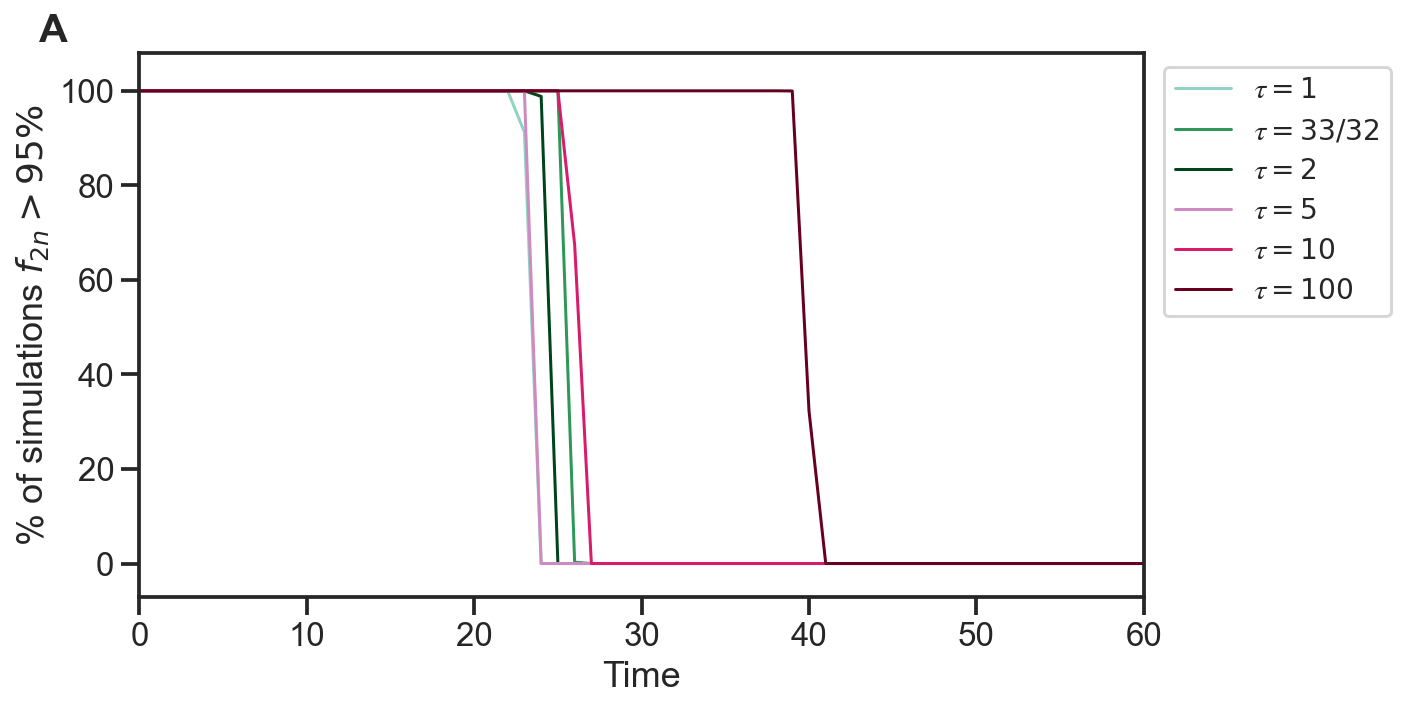

In [50]:
plot_accumulated_fixation(fixations0, labels, '2n')
plt.gcf().savefig(f'{output_path}/tau-diff-a.pdf', bbox_inches='tight', dpi=100)

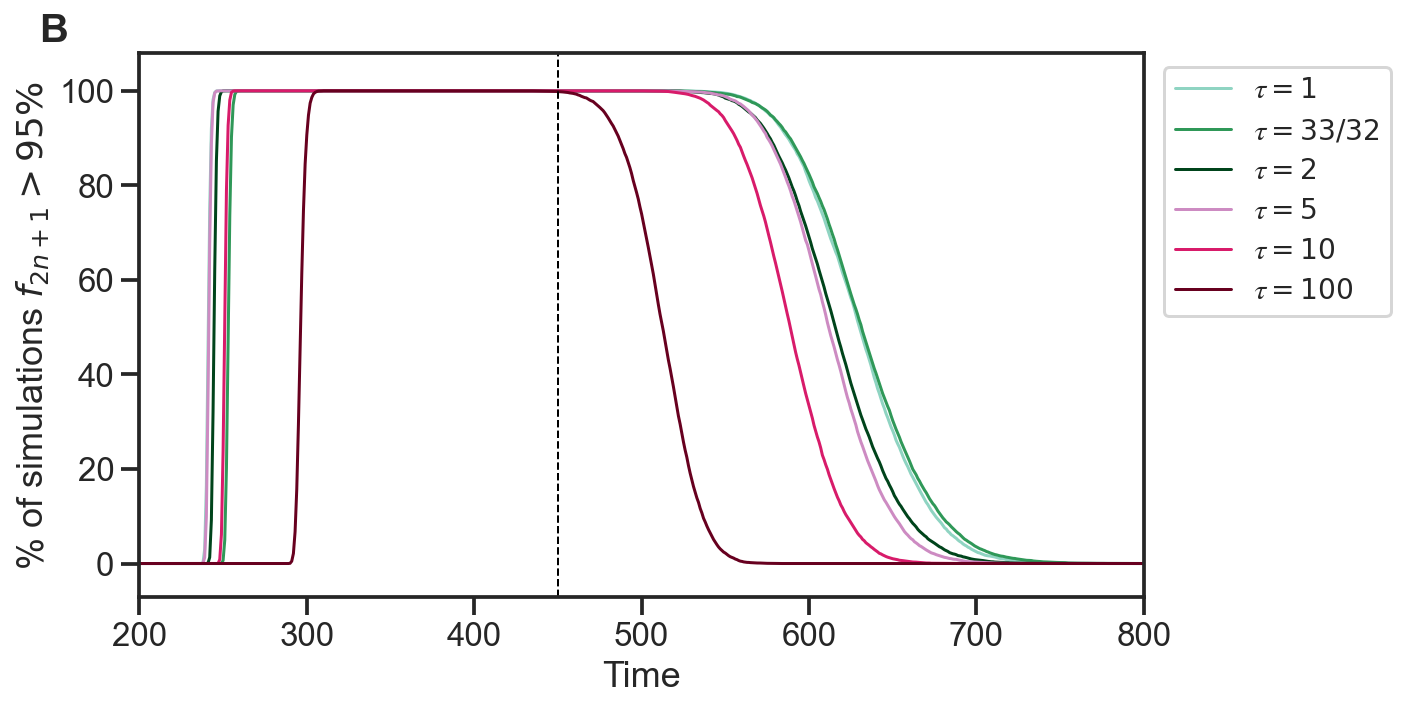

In [51]:
plot_accumulated_fixation(fixations1, labels, '2n+1')
plt.gcf().savefig(f'{output_path}/tau-diff-b.pdf', bbox_inches='tight', dpi=100)

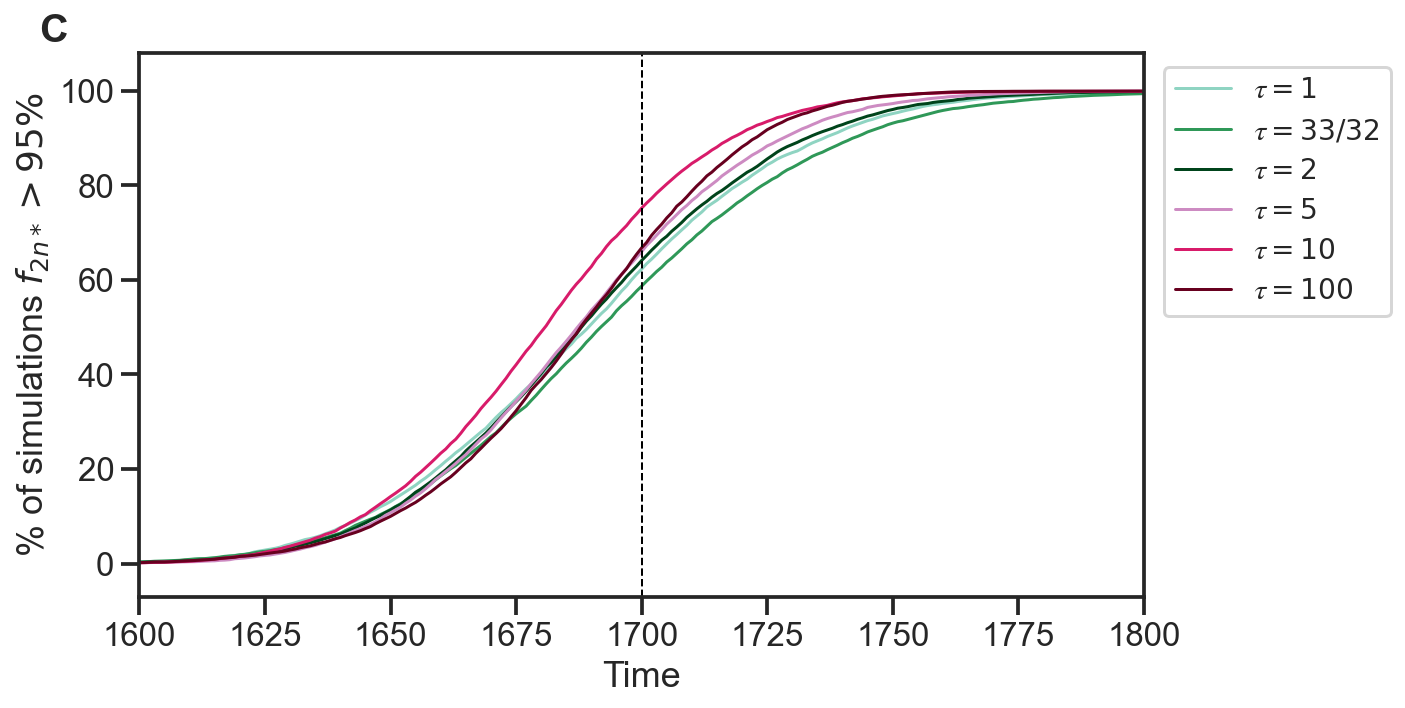

In [52]:
plot_accumulated_fixation(fixations3, labels, '2n*')
plt.gcf().savefig(f'{output_path}/tau-diff-c.pdf', bbox_inches='tight', dpi=100)